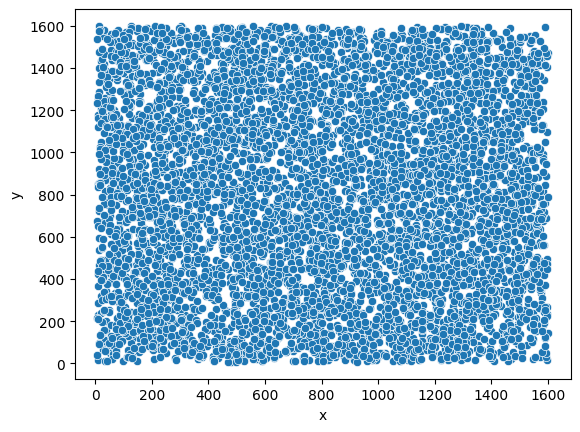

(6259, 201, 15, 15, 1)
(122, 201, 15, 15, 1)


In [1]:
## import pickle
import numpy as np
import matplotlib.pyplot as plt
from data.visualise import grid_psfs, show_psf_axial
from tifffile import imread
import pandas as pd
import seaborn as sns

def load_pickle_file(dpath):
    with open(dpath, 'rb') as f:
        return pickle.load(f)

# MQ_data     
stacks = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/stacks.ome.tif'
locs = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/beads_box15/combined/locs.hdf'
exclude_idx = [5, 7, 11, 14, 22, 24, 26, 27, 28, 31, 32, 35, 37, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]
Z_STEP = 20

# FD-deeploc data
stacks = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/stacks.ome.tif'
locs = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/Astigmatism_beads_stacks_2um/combined/locs.hdf'
exclude_idx = []
Z_STEP = 50

psfs = imread(stacks)
locs = pd.read_hdf(locs, key='locs')

psfs = psfs[:, :, :, :, np.newaxis]

# for i, psf in enumerate(psfs.sum(axis=-1)):
#     plt.title(str(i))
#     show_psf_axial(psf)


# exclude_idx = [0, 5, 7, 12, 22, 26, 32, 35, 38, 40, 45, 50, 51, 54, 68, 69, 71, 72, 82, 87, 89, 91, 98, 102, 108, 109, 112, 113, 115, 116, 121, 122, 123, 124, 127, 129, 131, 132, 133, 138, 141, 144, 150, 151, 154, 161, 167, 169, 170, 172, 178, 179, 181, 182, 184, 185, 186, 187, 190, 200, 201, 205, 206, 210, 214, 219, 221, 224, 226, 230, 233, 234, 235, 236, 237, 243]

# print('Excluded PSFs \n\n\n\n\n')
# for i in exclude_idx:
#     show_psf_axial(psfs[i].mean(axis=-1), str(i))
#     plt.plot(psfs[i].max(axis=(1,2)))
#     plt.show()
# print('End of excluded PSFs \n\n\n\n\n')

# print(psfs.shape[0])
# for i in range(psfs.shape[0]):
#     if i in exclude_idx:
#         continue
#     plt.title(str(i))
#     show_psf_axial(psfs[i].mean(axis=-1))
#     plt.plot(psfs[i].max(axis=(1,2,3)), label='max')
#     plt.legend()
#     plt.title(str(i))
#     plt.show()

idx = [i for i in range(psfs.shape[0]) if i not in exclude_idx]
psfs = psfs[idx]
locs = locs.iloc[idx]
locs['idx'] = np.arange(locs.shape[0])

sns.scatterplot(data=locs, x='x', y='y')
plt.show()

print(psfs.shape)

xlim = ((650, 850))
ylim = ((650, 850))
idx = (xlim[0] < locs['x']) & (locs['x'] < xlim[1]) & (ylim[0] < locs['y']) & (locs['y'] < ylim[1])
locs = locs[idx]
psfs = psfs[locs['idx']]

print(psfs.shape)


ys = []
for i in range(psfs.shape[0]):
    y = np.arange(psfs.shape[1]) * Z_STEP
    y = y - 1000
    ys.append(y)
ys = np.stack(ys)


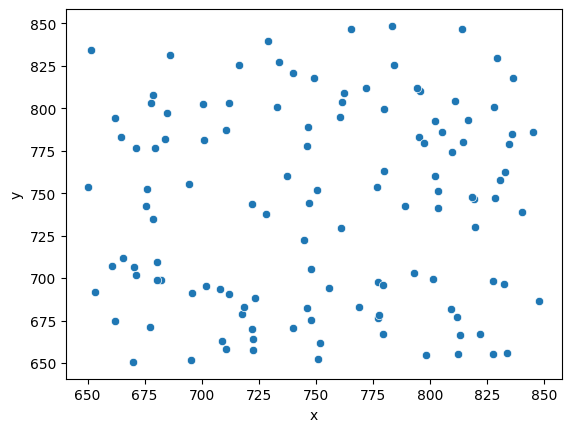

In [2]:
sns.scatterplot(data=locs, x='x', y='y')
plt.show()

In [3]:
# Zero offsets
offsets = np.zeros((psfs.shape[0]))

In [4]:
print(psfs.shape, ys.shape)

(122, 201, 15, 15, 1) (122, 201)


In [5]:
# from data.estimate_offset import estimate_offset

# for i, psf in enumerate(psfs):
#     ys[i] = estimate_offset(psf.squeeze(), (Z_STEP,), disable_boundary_check=True)


In [6]:
# ROTATION MATCHING ALIGNMENT

from skimage.filters import gaussian, butterworth
from data.align_psfs import norm_zero_one
from sklearn.metrics import euclidean_distances, mean_squared_error
import scipy.ndimage as ndi

UPSCALE_RATIO = 5
        
def find_seed_psf(df):
    n_points = 1
    # Seed PSF - most centered PSF in FOV
    center = df[['x', 'y']].mean(axis=0).to_numpy()
    coords = df[['x', 'y']].to_numpy()
    dists = euclidean_distances([center], coords).squeeze()
    return np.argsort(dists)[:n_points]
#     first_point = np.argmin(dists)
#     return first_point


def norm_sum_imgs(psf):
    psf_sums = psf.sum(axis=(1,2, 3))
    psf = psf / psf_sums[:, np.newaxis, np.newaxis, np.newaxis]
    return psf


def eval_roll(fixed, moving, roll, debug=False):
    fixed_section = fixed
    moving_section = moving    
    if roll < 0:
        moving_section = moving[-roll:]
        fixed_section = fixed_section[:moving_section.shape[0]]
    elif roll > 0:
        fixed_section = fixed[roll:]
        moving_section = moving_section[:fixed_section.shape[0]]

    score = mean_squared_error(fixed_section.flatten(), moving_section.flatten())
#     score = ((fixed_section-moving_section)**2).sum()
    if debug:
        plt.rcParams['figure.figsize'] = [10, 3]
        x = np.arange(fixed.shape[0])
        x_moving = np.arange(moving.shape[0]) + roll
        plt.title(f'full roll {roll}')
        
        plt.plot(x, moving.std(axis=(1,2)), label='original')
        plt.plot(x_moving, moving.std(axis=(1,2)), label='shifted')
        plt.plot(x, fixed.std(axis=(1,2)), label='seed')
        plt.xlim((-5, max((x.max(), x_moving.max()))))
        plt.legend()
        plt.show()
        
#         plt.title(f'{round(score, 2)} length {moving_section.shape[0]} roll {roll}')
#         plt.plot(moving_section.max(axis=(1,2)), label='moving')
#         plt.plot(fixed_section.max(axis=(1,2)), label='fixed')
#         plt.legend()
#         plt.show()   
        show_psf_axial(fixed.mean(axis=-1), 'fixed', 3*UPSCALE_RATIO)
        show_psf_axial(moving.mean(axis=-1), 'moving', 3*UPSCALE_RATIO)
        show_psf_axial(np.roll(moving.mean(axis=-1), roll, 0), f'shifted {roll}', 3*UPSCALE_RATIO)
        

    return score

def find_best_roll(fixed, moving):
    roll_min = -fixed.shape[0] // 2
    roll_max = fixed.shape[0] // 2
    best_roll = None
    min_score = np.inf
    
    rolls = []
    scores = []
    for roll in range(roll_min, roll_max, 1):
        score = eval_roll(fixed, moving, roll, debug=False)
        if score < min_score:
            best_roll = roll
            min_score = score
        rolls.append(roll)
        scores.append(score)
        
#     plt.plot(rolls, scores)
#     plt.xlabel('roll')
#     plt.ylabel('MSE')
#     plt.show()
    eval_roll(fixed, moving, best_roll, debug=True)
    return best_roll * (Z_STEP/UPSCALE_RATIO)


def upscale_psf(psf):
    out = ndi.zoom(psf, (UPSCALE_RATIO, 1, 1, 1), order=2)
    return out
    
def preprocess_psf(psf):
    psf = butterworth(psf, cutoff_frequency_ratio=0.2, high_pass=False)
    psf = norm_zero_one(psf)
    psf = upscale_psf(psf)
    return psf
    
def register_psfs(psfs, df):
    GAUSS_SIGMA = 1
    offsets = []
    seed_idx = find_seed_psf(df)
    seed_psf = preprocess_psf(psfs[seed_idx].mean(axis=0))
    
    for i in range(psfs.shape[0]):
        if i == seed_idx:
            offset = 0
        else:
            psf = preprocess_psf(psfs[i])
#             plt.plot(psf.max(axis=(1,2,3)))
#             plt.plot(seed_psf.max(axis=(1,2,3)))
#             plt.show()
            offset = find_best_roll(seed_psf, psf)
        offsets.append(offset)
    return np.array(offsets)

# offsets = register_psfs(psfs, locs)


2023-07-19 12:21:17.785867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 12:21:18.219162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
# SIMPLE ITK alignment

# import SimpleITK as sitk
# import numpy as np
# from data.align_psfs import norm_zero_one
# import pandas as pd
# from sklearn.metrics import euclidean_distances

# def command_iteration(method):
#     print(
#         f"{method.GetOptimizerIteration():3} "
#         + f" = {method.GetMetricValue():7.5f} "
#         + f" : {method.GetOptimizerPosition()}"
#     )        

# def arr_to_img(arr):
#     arr = norm_zero_one(arr.squeeze()).astype(np.float32)
#     img = sitk.GetImageFromArray(arr)
#     img = sitk.DiscreteGaussian(img)
#     return img


# def register_psf(psf, fixed):
#     moving = arr_to_img(psf)

#     R = sitk.ImageRegistrationMethod()

#     R.SetMetricAsMeanSquares()

#     R.SetOptimizerAsRegularStepGradientDescent(
#         learningRate=0.05,
#         minStep=1e-12,
#         numberOfIterations=10000,
#         gradientMagnitudeTolerance=1e-12,
#     )
#     R.SetOptimizerScalesFromIndexShift()

#     R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))

#     R.SetInterpolator(sitk.sitkLinear)

# #     R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

#     outTx = R.Execute(fixed, moving)
#     print("-------")
#     print(outTx)
#     print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
#     print(f" Iteration: {R.GetOptimizerIteration()}")
#     print(f" Metric value: {R.GetMetricValue()}")

#     return outTx.GetOffset()[2] * Z_STEP


# def find_seed_psf(df):
#     # Seed PSF - most centered PSF in FOV
#     center = df[['x', 'y']].mean(axis=0).to_numpy()
#     coords = df[['x', 'y']].to_numpy()
#     dists = euclidean_distances([center], coords).squeeze()
#     first_point = np.argmin(dists)
#     return first_point

# def register_psfs(psfs, df):
#     offsets = []
#     seed_idx = find_seed_psf(df)
    
#     ref = arr_to_img(psfs[seed_idx])

#     for i in range(psfs.shape[0]):
#         if i == seed_idx:
#             offset = 0
#         else:
#             offset = register_psf(psfs[i], ref)
#         offsets.append(offset)
#     return offsets


# # offsets = register_psfs(psfs, locs)
# # offsets = np.array(offsets)
# # offset_backup = offsets.copy()

In [8]:
# Spline peak finding
# from tqdm import tqdm

# from scipy.interpolate import UnivariateSpline
# from data.align_psfs import norm_zero_one

# UPSCALE_RATIO = 10

# def find_peak(psf):
#     if psf.ndim == 4:
#         psf = psf.mean(axis=-1)
#     x = np.arange(psf.shape[0]) * Z_STEP
#     inten = norm_zero_one(psf.max(axis=(1,2)))
# #   prev 0.8
#     cs = UnivariateSpline(x, inten, k=3, s=1.25)

#     x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP
    
#     peak = x_ups[np.argmax(cs(x_ups))] 
    
#     plt.plot(x-peak, inten, label='raw')
#     plt.plot(x_ups-peak, cs(x_ups), label='fit')
#     plt.legend()
#     plt.show()
#     return peak

# offsets = np.array([find_peak(psf) for psf in tqdm(psfs)])

In [9]:
# # Skew gaussian peak finding
# from skimage.filters import butterworth
# plt.rcParams['figure.figsize'] = [10, 3]

# from scipy.optimize import curve_fit
# from scipy.stats import norm

# def skew(x, s, e=0, w=1, a=0, c=0):
#     t = (x - e) / w
#     return (s * norm.pdf(t) * norm.cdf(a * t)) + c


# def fit_gaussian(x, y):
#     mean = np.argmax(y)
#     peak = np.max(y)
#     min_val = np.min(y)
#     bounds = [
#         (0, peak * 10),
#         (np.percentile(x, 25), np.percentile(x, 75)),
#         (0, max(x)),
#         (-10, 10),
#         (0, np.max(y))
#     ]
#     low_bounds, high_bounds = zip(*bounds)

#     p0 = [max(y), np.mean(x), np.std(x), 0, np.mean(y)]
#     popt, _ = curve_fit(skew, x, y, p0=p0, bounds=(low_bounds, high_bounds),
#                         maxfev=10000)
#     return lambda x: skew(x, *popt)

# def find_peak(psf):
#     psf2 = butterworth(psf, cutoff_frequency_ratio=0.2, high_pass=False)
#     y = psf2.max(axis=(1,2,3))
#     zs = np.arange(psf.shape[0]) * Z_STEP
#     high_res_z = np.linspace(zs.min(), zs.max(), 10000)
#     high_res_fit = fit_gaussian(zs, y)(high_res_z)
    
#     offset = high_res_z[np.argmax(high_res_fit)]
#     plt.plot(zs, y, label='raw')
#     plt.plot(high_res_z, high_res_fit, label='fit')
#     plt.legend()
#     plt.show()
#     return offset
    
# offsets = np.array([find_peak(psf) for psf in psfs])


In [10]:
# offsets = [0] * psfs.shape[0]
for i in range(len(offsets)):
    ys[i] = ys[i] - offsets[i]

In [11]:
# ys = []
# for i, offset in zip(list(range(psfs.shape[0])), offsets):
#     y = np.arange(psfs.shape[1]) * Z_STEP
#     ys.append(y-offset)
# ys = np.stack(ys)


In [12]:
# valid_idx = np.argwhere(abs(offsets)<750).squeeze()
# psfs = psfs[valid_idx]
# coords = coords[valid_idx]
# ys = ys[valid_idx]

# offsets = offsets[valid_idx]

In [13]:
# Re-center z positions using average peak

peak_zs = []
for psf, z in zip(psfs, ys):
    peak = np.argmax(psf.max(axis=(1,2,3)))
    peak_zs.append(z[peak])
    
mean_peak = np.mean(peak_zs)
print(mean_peak)
ys = ys - mean_peak



4021.72131147541


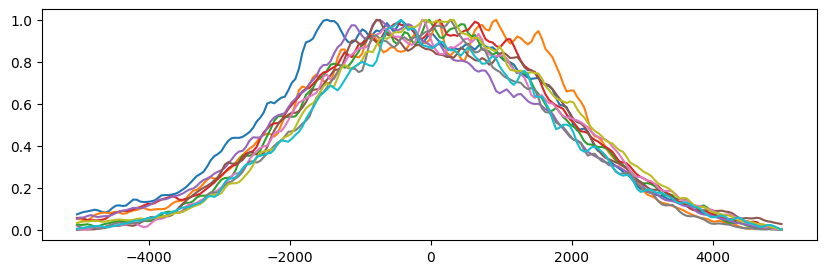

In [14]:
from data.align_psfs import norm_zero_one
from skimage.filters import gaussian

plt.rcParams['figure.figsize'] = [10, 3]
for psf, z in list(zip(psfs, ys))[0:10]:
    y = norm_zero_one(gaussian(psf).std(axis=(1,2,3))).squeeze()
#     show_psf_axial(psf.squeeze(), '', 1)
    plt.plot(z, y)
# plt.xlim((-1000, 1000))
plt.show()

Train


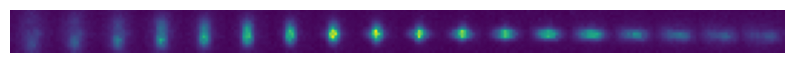

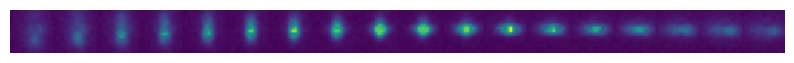

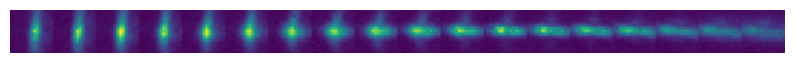

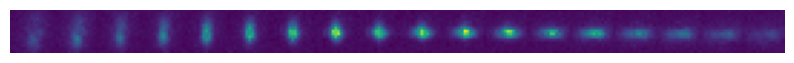

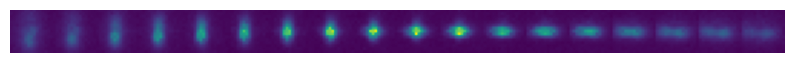

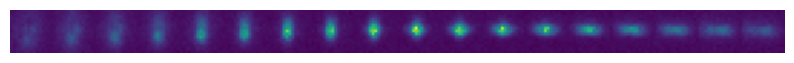

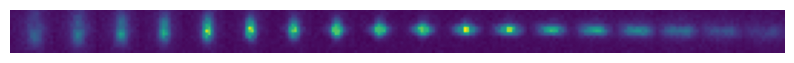

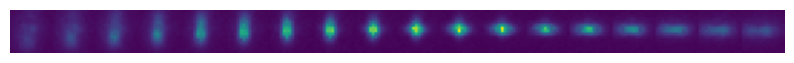

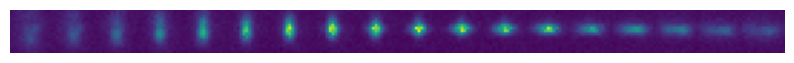

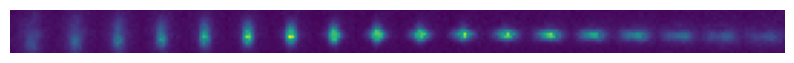

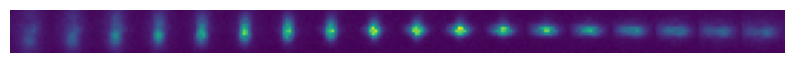

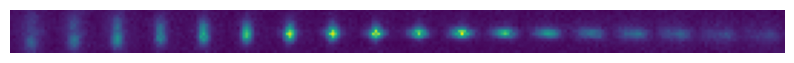

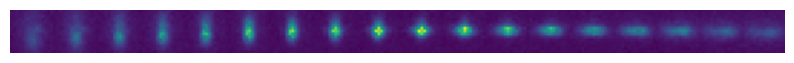

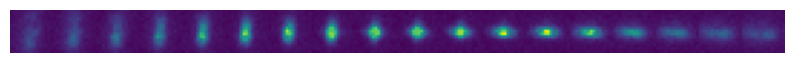

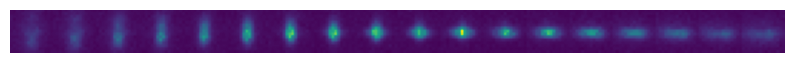

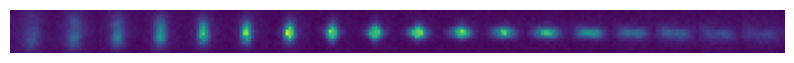

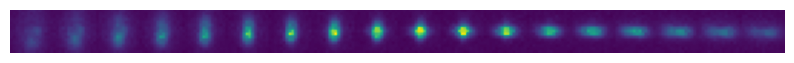

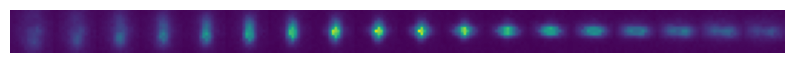

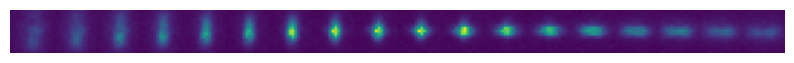

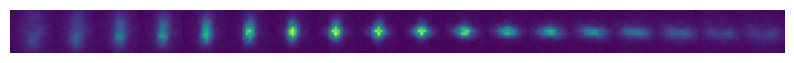

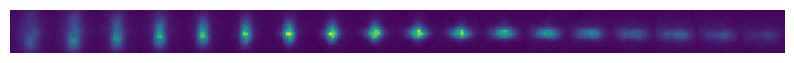

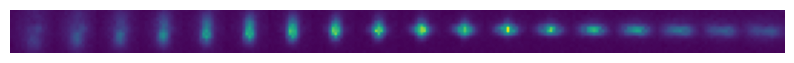

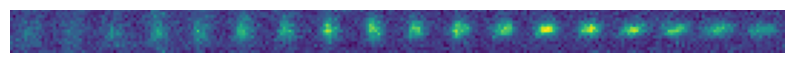

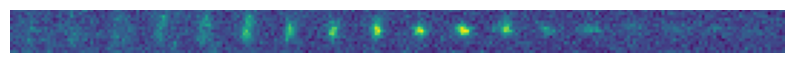

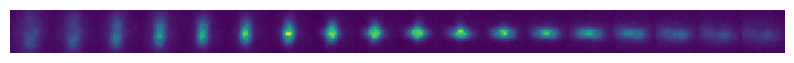

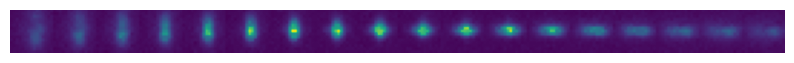

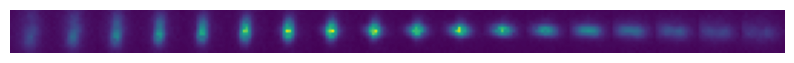

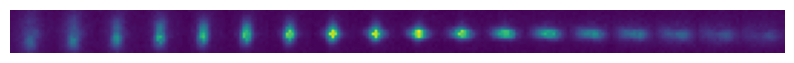

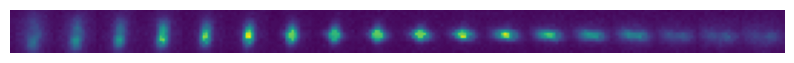

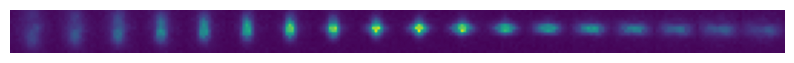

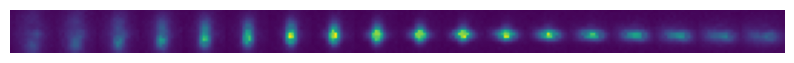

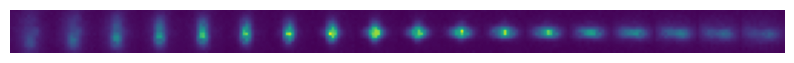

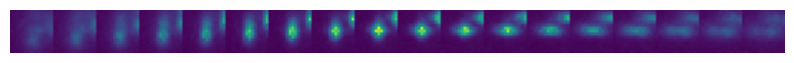

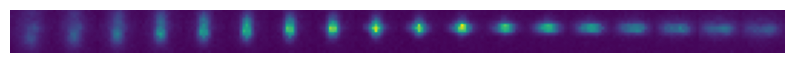

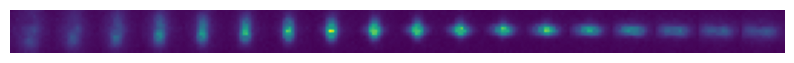

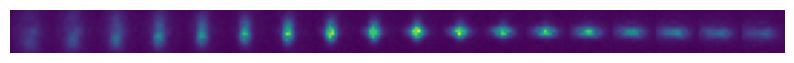

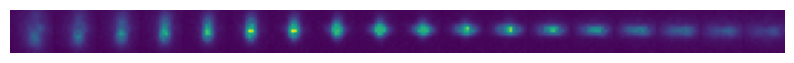

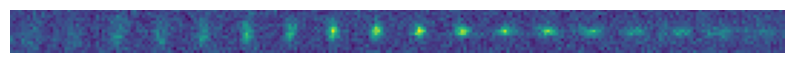

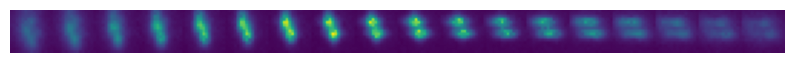

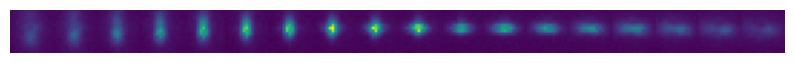

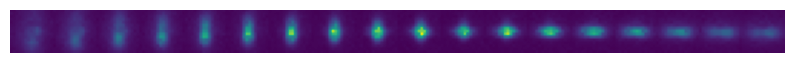

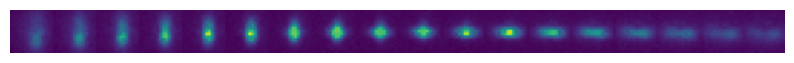

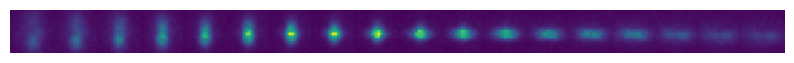

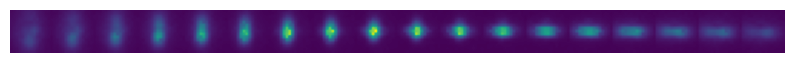

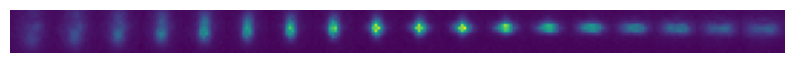

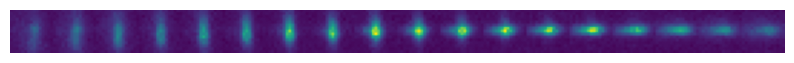

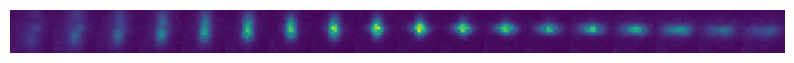

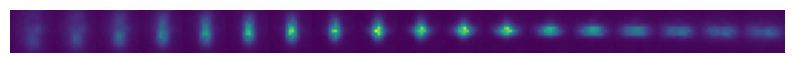

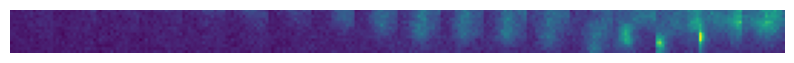

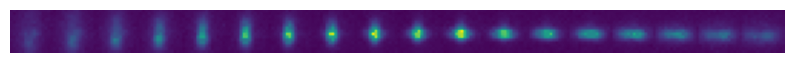

Val


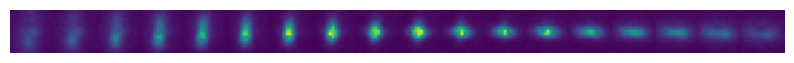

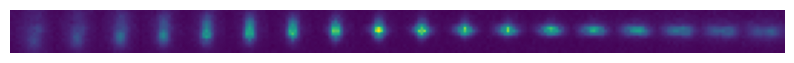

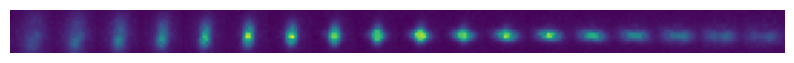

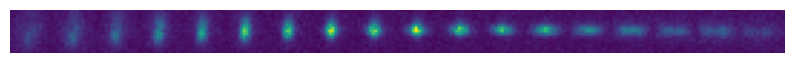

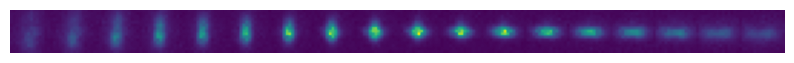

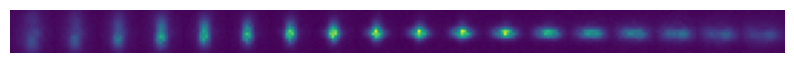

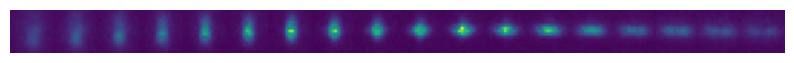

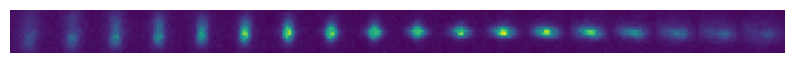

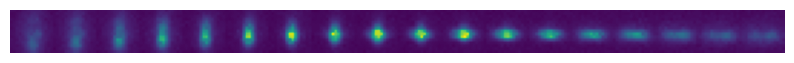

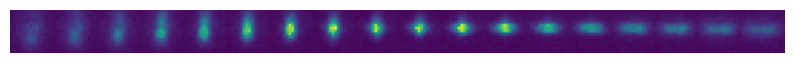

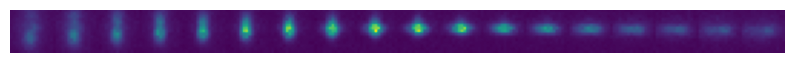

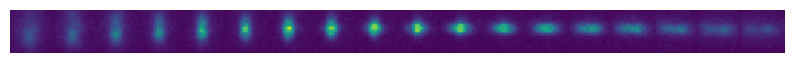

Test


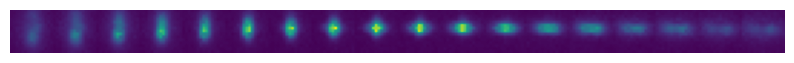

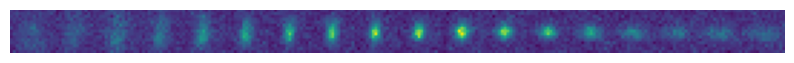

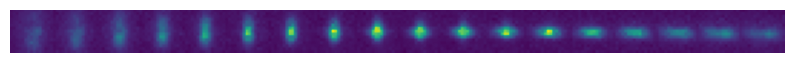

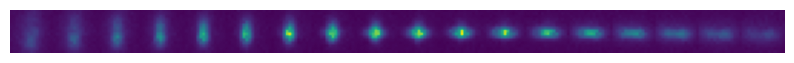

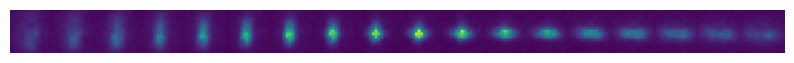

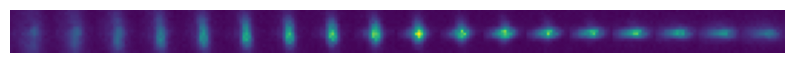

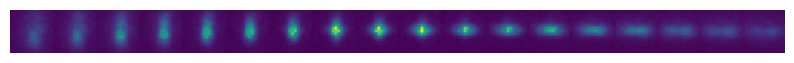

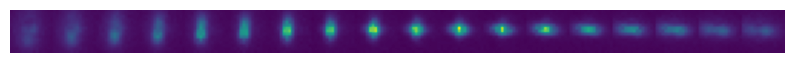

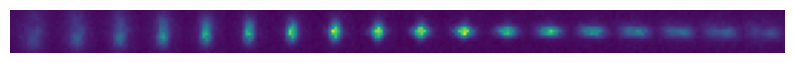

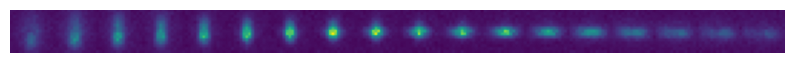

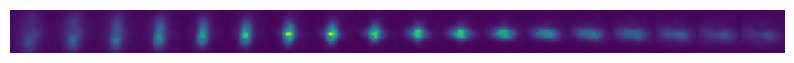

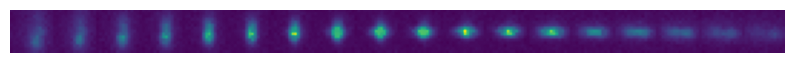

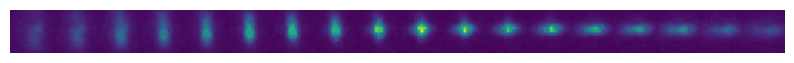

In [15]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
SEED = 43
train_size = 0.8

test_size = 0.5

idx = list(range(0, psfs.shape[0]))

coords = locs[['x', 'y']].to_numpy()[:, np.newaxis]
coords = np.repeat(coords, psfs.shape[1], 1)

train_idx, other_idx = train_test_split(idx, train_size=train_size, random_state=SEED, shuffle=True)
val_idx, test_idx = train_test_split(other_idx, test_size=test_size, random_state=SEED, shuffle=True)

X_train = psfs[train_idx], coords[train_idx]
y_train = ys[train_idx]

X_val = psfs[val_idx], coords[val_idx]
y_val = ys[val_idx]

X_test = psfs[test_idx], coords[test_idx]
y_test = ys[test_idx]



from data.visualise import grid_psfs, show_psf_axial
import seaborn as sns

# sns.scatterplot(data=locs, x='x', y='y')
# plt.show()
plt.rcParams['figure.figsize'] = [10, 10]
print('Train')
for psf in X_train[0][0:50]:
    show_psf_axial(psf.sum(axis=-1))
    
print('Val')
for psf in X_val[0][0:50]:
    show_psf_axial(psf.sum(axis=-1))
    
    
print('Test')
for psf in X_test[0][0:50]:
    show_psf_axial(psf.sum(axis=-1))
    

In [16]:
print(y_train.min(), y_train.max())
print(y_val.min(), y_val.max())
print(y_test.min(), y_test.max())

-5021.72131147541 4978.27868852459
-5021.72131147541 4978.27868852459
-5021.72131147541 4978.27868852459


In [17]:
print(X_train[0].shape, X_train[1].shape, y_train.shape)
print(X_val[0].shape, X_val[1].shape, y_val.shape)
print(X_test[0].shape, X_test[1].shape, y_test.shape)

print(X_train[0].min(), X_train[0].mean(), X_train[0].max())
print(X_val[0].min(), X_val[0].mean(), X_val[0].max())
print(X_test[0].min(), X_test[0].mean(), X_test[0].max())

(97, 201, 15, 15, 1) (97, 201, 2) (97, 201)
(12, 201, 15, 15, 1) (12, 201, 2) (12, 201)
(13, 201, 15, 15, 1) (13, 201, 2) (13, 201)
175 413.9919292426755 8975
192 390.9116399484061 4293
190 388.9923374580091 4928


In [18]:
import numpy as np

def concat_training_datasets(X_train, y_train, X_val, y_val, X_test, y_test):
    X_train = list(X_train)
    X_val = list(X_val)
    X_test = list(X_test)
    for i in range(2):
        X_train[i] = np.concatenate(X_train[i]).astype(float)
        X_val[i] = np.concatenate(X_val[i]).astype(float)
        X_test[i] = np.concatenate(X_test[i]).astype(float)

    y_train = np.concatenate(y_train).astype(float)
    y_val = np.concatenate(y_val).astype(float)
    y_test = np.concatenate(y_test).astype(float)

    print(X_train[0].shape, X_train[1].shape)
    print(X_val[0].shape, X_val[1].shape)
    print(X_test[0].shape, X_test[1].shape)


    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = concat_training_datasets(X_train, y_train, X_val, y_val, X_test, y_test)

(19497, 15, 15, 1) (19497, 2)
(2412, 15, 15, 1) (2412, 2)
(2613, 15, 15, 1) (2613, 2)
(19497,)
(2412,)
(2613,)


In [19]:
# Trim stacks

Z_RANGE = 1000
def filter_z_datasets(X_train, y_train, X_val, y_val, X_test, y_test):
    def filter_z_range(X, zs):
        psfs, coords = X
        print(psfs.shape, coords.shape, zs.shape)
        valid_ids = np.argwhere(abs(zs.squeeze()) < Z_RANGE).squeeze()
        return [psfs[valid_ids], coords[valid_ids]], zs[valid_ids]

    X_train, y_train = filter_z_range(X_train, y_train)
    X_val, y_val = filter_z_range(X_val, y_val)
    X_test, y_test = filter_z_range(X_test, y_test)

    print(X_train[0].min(), X_train[0].mean(), X_train[0].max())
    print(X_val[0].min(), X_val[0].mean(), X_val[0].max())
    print(X_test[0].min(), X_test[0].mean(), X_test[0].max())

    print(y_train.min(), y_train.max())
    print(y_val.min(), y_val.max())
    print(y_test.min(), y_test.max())

    print(X_train[0].shape, X_train[1].shape)
    print(X_val[0].shape, X_val[1].shape)
    print(X_test[0].shape, X_test[1].shape)


    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = filter_z_datasets(X_train, y_train, X_val, y_val, X_test, y_test)

(19497, 15, 15, 1) (19497, 2) (19497,)
(2412, 15, 15, 1) (2412, 2) (2412,)
(2613, 15, 15, 1) (2613, 2) (2613,)
182.0 452.9320355097365 8975.0
192.0 425.6066666666667 4293.0
195.0 423.1991965811966 4928.0
-971.72131147541 978.27868852459
-971.72131147541 978.27868852459
-971.72131147541 978.27868852459
(3880, 15, 15, 1) (3880, 2)
(480, 15, 15, 1) (480, 2)
(520, 15, 15, 1) (520, 2)
(3880,)
(480,)
(520,)


In [20]:
print(X_train[0].min(), X_train[0].mean(), X_train[0].max())
print(X_val[0].min(), X_val[0].mean(), X_val[0].max())
print(X_test[0].min(), X_test[0].mean(), X_test[0].max())

print(y_train.min(), y_train.max())
print(y_val.min(), y_val.max())
print(y_test.min(), y_test.max())

182.0 452.9320355097365 8975.0
192.0 425.6066666666667 4293.0
195.0 423.1991965811966 4928.0
-971.72131147541 978.27868852459
-971.72131147541 978.27868852459
-971.72131147541 978.27868852459


In [21]:
# data augmentation


from tensorflow.keras import layers, Sequential
from data.visualise import grid_psfs

# def aug_dataset(X_train, y_train):
#     AUG_RATIO = 0.5
#     MAX_TRANSLATION_PX = 2
#     MAX_GAUSS_NOISE = 0.001
#     img_size = X_train[0].shape[1]

#     aug_pipeline = Sequential([
#         layers.GaussianNoise(stddev=MAX_GAUSS_NOISE*X_train[0].max(), seed=SEED),
#         layers.RandomTranslation(MAX_TRANSLATION_PX/img_size, MAX_TRANSLATION_PX/img_size, seed=SEED),
#         layers.RandomBrightness(0.2, [X_train[0].min(), X_train[0].max()], seed=SEED)
#     ])

#     idx = np.random.randint(0, X_train[0].shape[0], size=int(AUG_RATIO*X_train[0].shape[0]))

#     aug_psfs = aug_pipeline(X_train[0][idx].copy(), training=True).numpy()
#     aug_coords = X_train[1][idx]

#     aug_z = y_train[idx]

#     subset_psfs = np.concatenate((aug_psfs[0:100], X_train[0][idx][0:100]))
#     plt.imshow(grid_psfs(subset_psfs.mean(axis=-1)))
#     plt.show()

#     train_psfs = np.concatenate([aug_psfs, X_train[0]])
#     train_coords = np.concatenate([aug_coords, X_train[1]])
#     train_zs = np.concatenate([aug_z, y_train])

#     X_train = [train_psfs, train_coords]
#     y_train = train_zs
#     return X_train, y_train


# X_train, y_train = aug_dataset(X_train, y_train)
    


In [22]:
# from skimage.transform import rescale
# plt.rcParams['figure.figsize'] = [3, 3]
# def bin_pixels(img):
#     subsample_ratio = 2
#     new_shape = [s//subsample_ratio for s in img.shape[0:2]] + [1]
#     new_img = rescale(img, 1/subsample_ratio, anti_aliasing=False)
    
#     upscaled_img = rescale(new_img, (subsample_ratio, subsample_ratio, 1), anti_aliasing=False, order=0)
# #     plt.imshow(img)
# #     plt.show()
# #     plt.imshow(new_img)
# #     plt.title(new_img.shape)
# #     plt.show()
    
# #     plt.imshow(upscaled_img)
# #     plt.title(upscaled_img.shape)
# #     plt.show()
#     return upscaled_img

# plt.imshow(X_train[0])
# plt.show()
# X_train = np.stack([bin_pixels(img) for img in X_train])
# X_val = np.stack([bin_pixels(img) for img in X_val])
# X_test = np.stack([bin_pixels(img) for img in X_test])
# plt.imshow(X_train[0])
# plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler

def min_max_xy_coords(X_train, X_val, X_test):
    coords_scaler = MinMaxScaler().fit(X_train[1])
    X_train[1] = coords_scaler.transform(X_train[1])
    X_val[1] = coords_scaler.transform(X_val[1])
    X_test[1] = coords_scaler.transform(X_test[1])
    return coords_scaler


coords_scaler = min_max_xy_coords(X_train, X_val, X_test)




In [24]:
from skimage.transform import resize
from tqdm import tqdm
def resize_psfs(X_train, X_val, X_test):
    target_size = 128
    imshape = (target_size, target_size, 3)

    X_train[0] = np.stack([resize(psf, imshape) for psf in tqdm(X_train[0])])
    X_val[0] = np.stack([resize(psf, imshape) for psf in tqdm(X_val[0])])
    X_test[0] = np.stack([resize(psf, imshape) for psf in tqdm(X_test[0])])
    

resize_psfs(X_train, X_val, X_test)

100%|████████████████████████████████████████| 520/520 [00:01<00:00, 405.50it/s]


In [25]:
# Data exploration


# import seaborn as sns
# plt.rcParams['figure.figsize'] = [5, 3]
# for name, metric in [('mean', np.mean), ('max', np.max), ('min', np.min), ('std', np.std)]:
#     vals = {}
#     for k, X, y in [('train', X_train, y_train), ('val', X_val, y_val)]:
#         psfs, coords = X
#         val = metric(psfs, axis=(1,2,3))
#         vals[k] = val
#     sns.histplot(vals, common_norm=False, stat='density')
#     plt.yscale('log')
#     plt.title(name)
#     plt.show()

# for band_center in np.arange(-500, 500, 100):
#     start = band_center - 50
#     end = band_center + 50
#     plt.title(f'band {band_center}+-50')
    
#     vals = {}
#     for k, X, y in [('train', X_train, y_train), ('val', X_val, y_val)]:
#         idx = np.argwhere((start<=y.squeeze())&(y.squeeze()<=end)).squeeze()
#         n = 3
#         idx = np.random.choice(idx, n)
#         psfs = X[0][idx]
#         for i, psf in enumerate(psfs):
#             vals[f'{k}_{i}'] = psf.flatten()
#         plt.xscale('log')
        
#     sns.histplot(vals, common_norm=False, stat='density', kde=True, fill=False)
#     plt.show()
    
# train_imgs = X_train[0]
# val_imgs = X_val[0]
# zs = np.concatenate((y_train, y_val))
# labels = ['train'] * train_imgs.shape[0] + ['val'] * val_imgs.shape[0]
# imgs = np.concatenate((train_imgs, val_imgs))
# imgs = imgs.reshape((imgs.shape[0], -1))
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2).fit_transform(imgs)
# sns.scatterplot(tsne[:, 0], tsne[:, 1], hue=labels, sizes=(1,10), size=zs.squeeze())

In [26]:
psfs.shape, ys.shape, coords.shape

((122, 201, 15, 15, 1), (122, 201), (122, 201, 2))

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_imgs(X_train, X_val, X_test):
    datagen = ImageDataGenerator(
        rescale=1.0/65336.0,
        samplewise_center=False,
        samplewise_std_normalization=False,
        featurewise_center=True,
        featurewise_std_normalization=True,
        horizontal_flip=False)
    
    print('Fitting datagen...')
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_train[0])
    print('Fitted')

    X_train_preproc = [X_train[0].copy(), X_train[1].copy()]
    X_val_preproc = [X_val[0].copy(), X_val[1].copy()]
    X_test_preproc = [X_test[0].copy(), X_test[1].copy()]

    X_train_preproc[0] = datagen.standardize(X_train_preproc[0])
    X_val_preproc[0] = datagen.standardize(X_val_preproc[0])
    X_test_preproc[0] = datagen.standardize(X_test_preproc[0])
    
    return X_train_preproc, X_val_preproc, X_test_preproc, datagen


X_train_preproc, X_val_preproc, X_test_preproc, datagen = preprocess_imgs(X_train, X_val, X_test)

preprocessors = {
    'psfs': datagen,
    'coords': coords_scaler
}

import pickle
with open('./scalers.p', 'wb') as f:
    pickle.dump(preprocessors, f)

Fitting datagen...
Fitted


In [28]:
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm.keras import TqdmCallback
from tensorflow.keras import regularizers

import tensorflow as tf

def train_model(X_train_preproc, y_train, X_val_preproc, y_val):
    img_input = layers.Input((X_train_preproc[0][0].shape))
    coords_input = layers.Input(X_train_preproc[1][0].shape)

    x = img_input
    
#     x = keras.applications.ResNet50V2(
#         input_tensor = img_input,
#         include_top=False,
#         pooling='avg',
#     )(x)

#     x = keras.applications.MobileNetV3Small(
#         input_tensor=img_input,
#         include_top=False,
#         pooling='avg',
#     )(x)
    x = keras.applications.MobileNet(
        input_tensor=img_input,
        include_top=False,
        weights='./mobilenet_1_0_128_tf_no_top.h5',
        pooling='avg',
    )(x)

    x = tf.concat([x, coords_input], axis=-1)

    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation="linear",
                       kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                       bias_regularizer=regularizers.L2(1e-4),
                       activity_regularizer=regularizers.L2(1e-5)
                      )(x)

    model = keras.Model(inputs=(img_input, coords_input), outputs=out)

    model.summary(expand_nested=False)


    batch_size = 32
    epochs = 5000
    lr = 0.001

    model.compile(loss='mean_squared_error', optimizer=optimizers.AdamW(learning_rate=lr), metrics=['mean_absolute_error'])

    callbacks = [
        ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.1,
                          patience=25, verbose=True, mode='min', min_delta=5, min_lr=1e-6,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=75,
                      verbose=False, min_delta=1, restore_best_weights=True),
        TqdmCallback(verbose=1),
    ]


    history = model.fit(X_train_preproc, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_preproc, y_val), callbacks=callbacks, shuffle=True, verbose=False)

    model.save('./latest_model')
    return model, history


model, history = train_model(X_train_preproc, y_train, X_val_preproc, y_val)

# Peak alignment
# 5.424, 114, 95
# w/ aug 5.19, 113, 96
# w/ more data and brightness aug 5.5, 119.52, 89
# Using smoothed peaks (s=1.25) 63, 74, 67
# 9.396, 78, 64.52



# FD-DEEPLOC DATA
# No stopping, 6.5, 191, mean offset 152

2023-07-19 12:21:39.113195: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21988 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 mobilenet_1.00_None (Functiona  (None, 1024)        3228864     ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                              

2023-07-19 12:21:44.509970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-07-19 12:21:45.130230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-19 12:21:45.130512: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x398a7c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 12:21:45.130523: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-07-19 12:21:45.133717: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 12:21:45.219665: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce


Epoch 78: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 103: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 128: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



2023-07-19 12:25:36.159639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1026]
	 [[{{node inputs}}]]
2023-07-19 12:25:37.540120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1026]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./latest_model/assets


INFO:tensorflow:Assets written to: ./latest_model/assets


In [29]:
from sklearn.metrics import mean_absolute_error
for k, (X, y) in [('train', (X_train_preproc, y_train)), ('val', (X_val_preproc, y_val))]:
    res = model.predict(X, verbose=True)
    error = mean_absolute_error(res, y)
    print(k, round(error, 3))

122/122 [==============================] - 1s 4ms/step
train 34.296
15/15 [==============================] - 0s 4ms/step
val 82.217


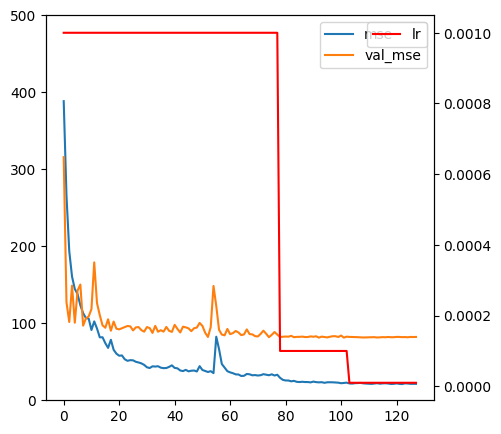

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]
fig, ax1 = plt.subplots()
ax1.plot(history.history['mean_absolute_error'], label='mse')
ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
ax1.set_ylim([0, 500])
ax1.legend(loc=1)
ax2 = ax1.twinx()
ax2.plot(history.history['lr'], label='lr', color='red')
ax2.legend(loc=0)


2/2 [==============================] - 0s 3ms/step


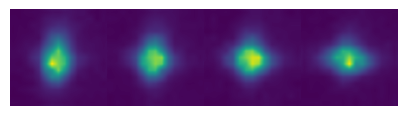

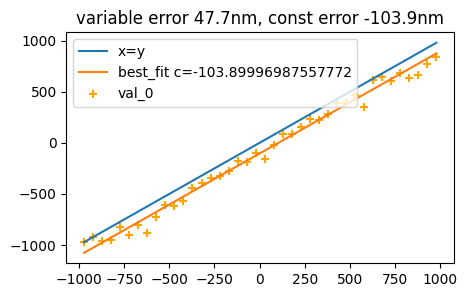

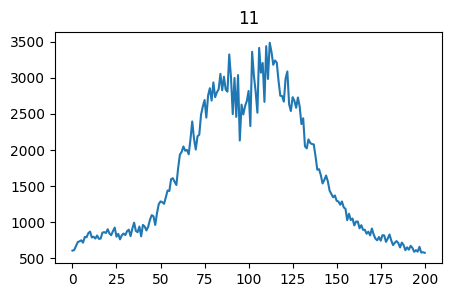

2/2 [==============================] - 0s 3ms/step


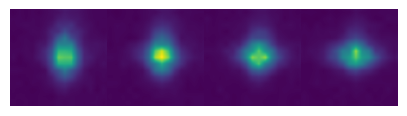

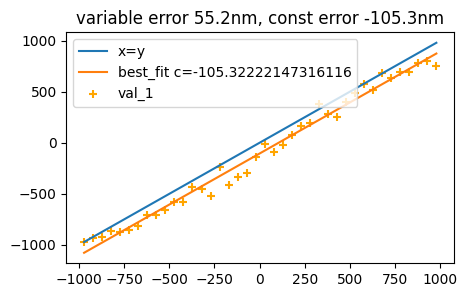

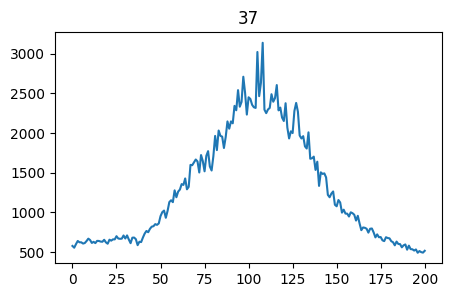

2/2 [==============================] - 0s 3ms/step


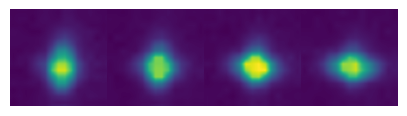

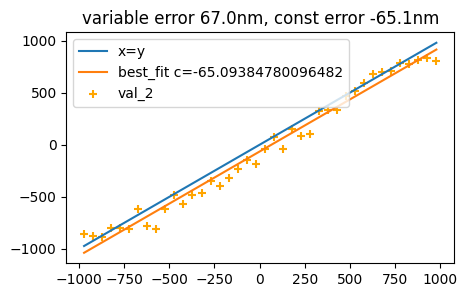

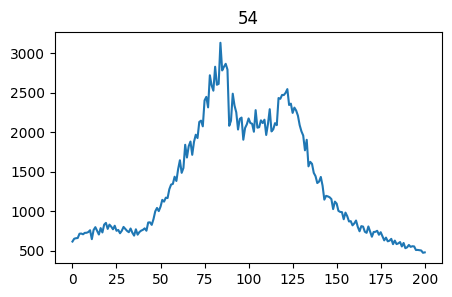

2/2 [==============================] - 0s 3ms/step


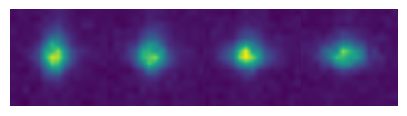

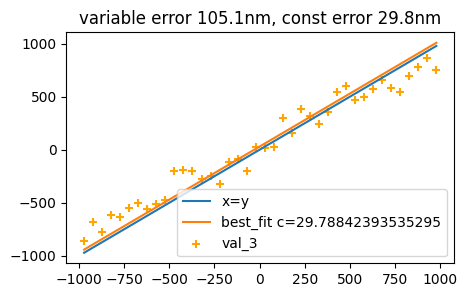

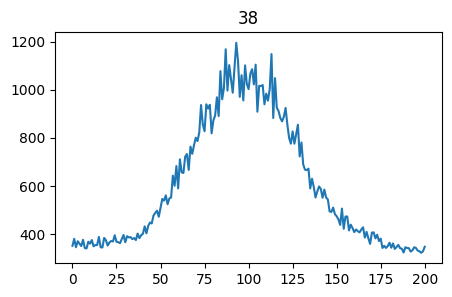

2/2 [==============================] - 0s 3ms/step


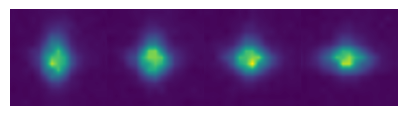

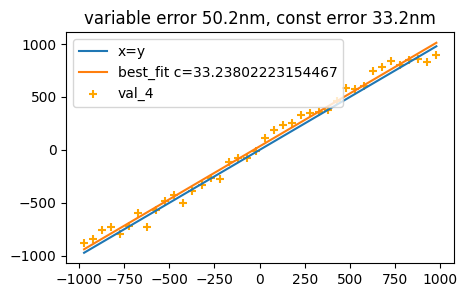

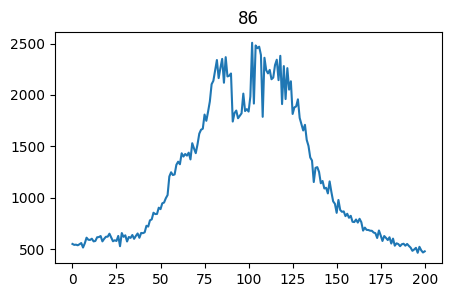

2/2 [==============================] - 0s 4ms/step


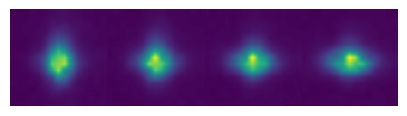

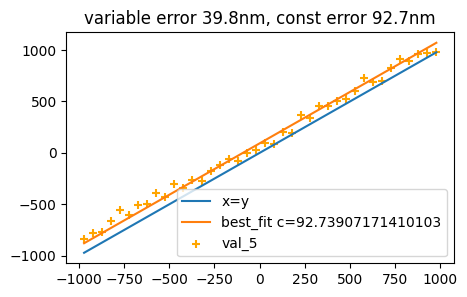

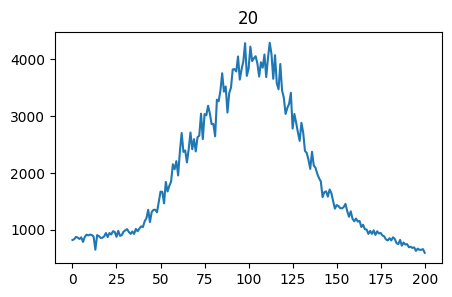

2/2 [==============================] - 0s 4ms/step


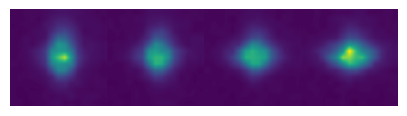

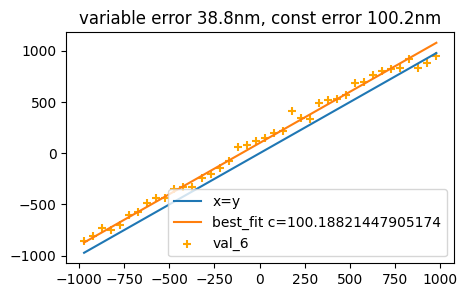

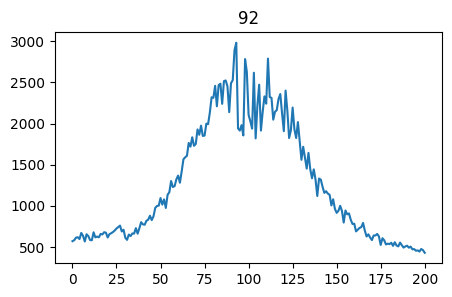

2/2 [==============================] - 0s 4ms/step


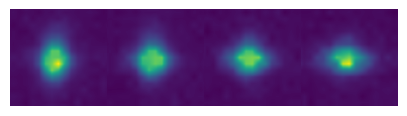

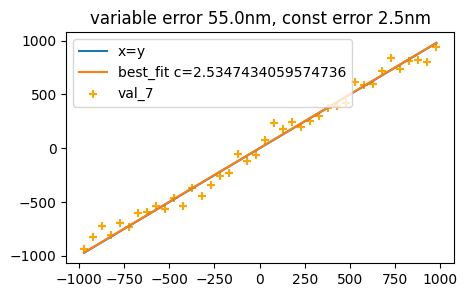

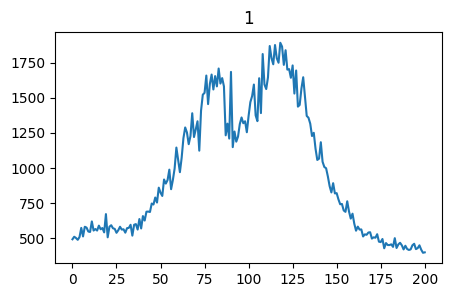

2/2 [==============================] - 0s 3ms/step


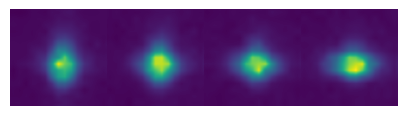

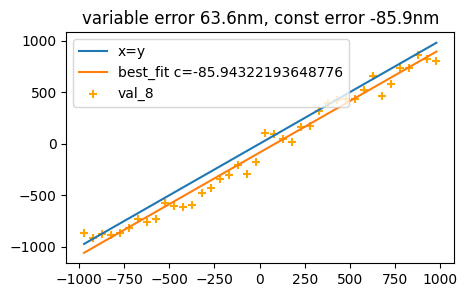

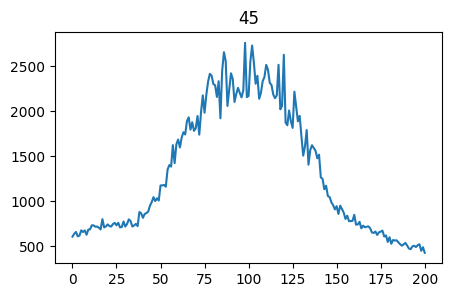

2/2 [==============================] - 0s 4ms/step


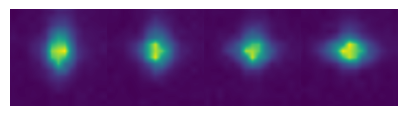

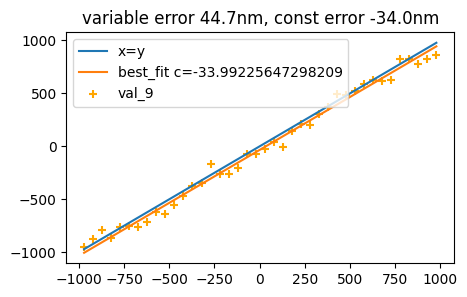

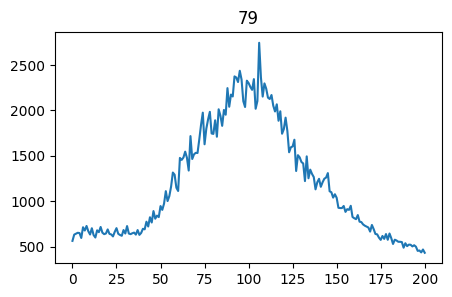

2/2 [==============================] - 0s 3ms/step


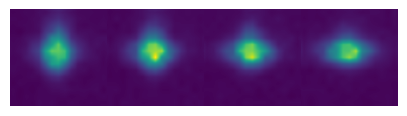

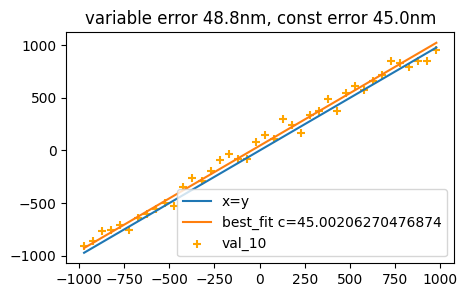

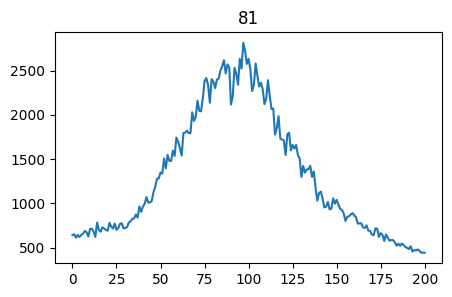

2/2 [==============================] - 0s 4ms/step


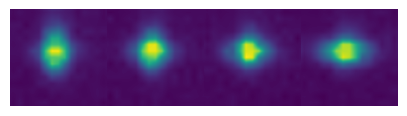

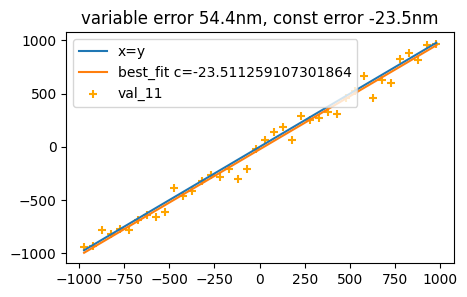

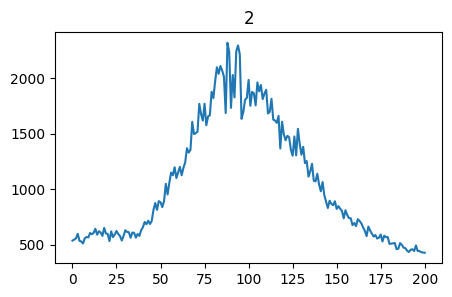

2/2 [==============================] - 0s 4ms/step


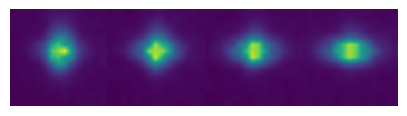

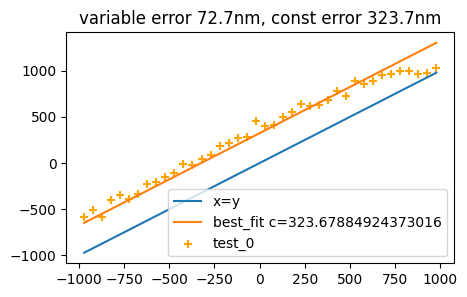

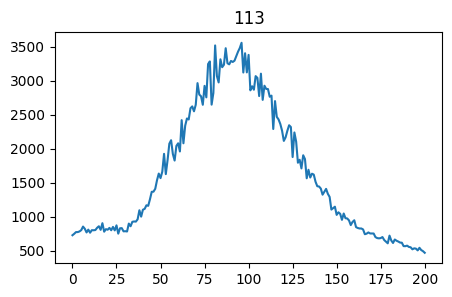

2/2 [==============================] - 0s 3ms/step


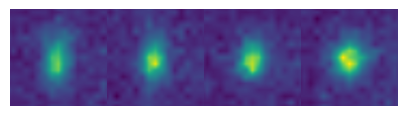

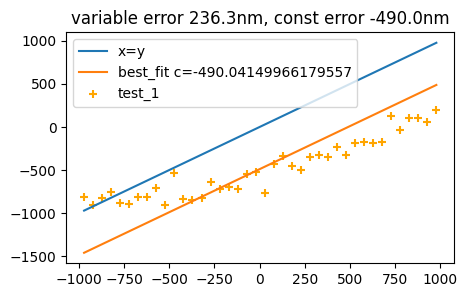

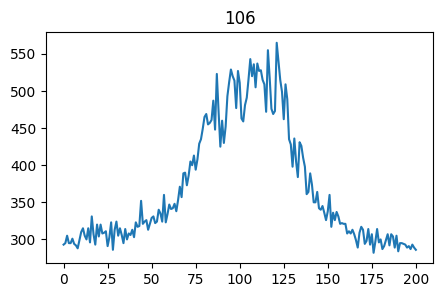

2/2 [==============================] - 0s 4ms/step


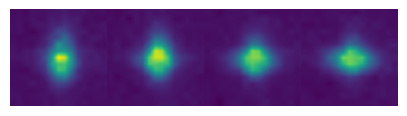

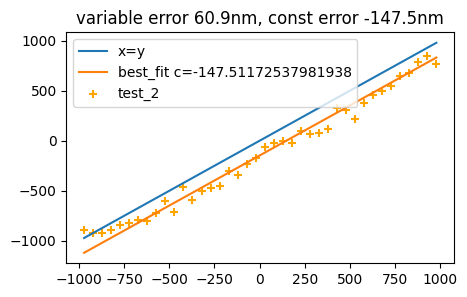

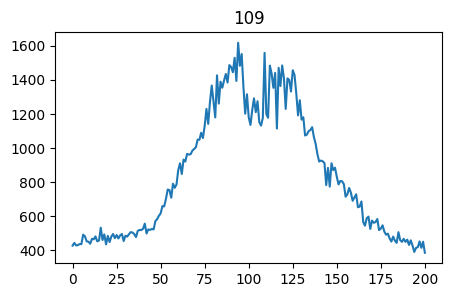

2/2 [==============================] - 0s 4ms/step


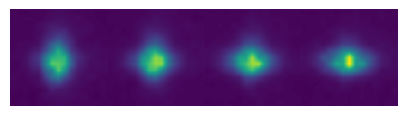

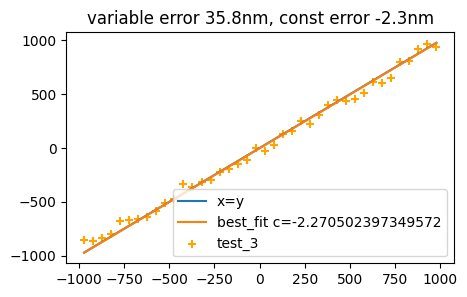

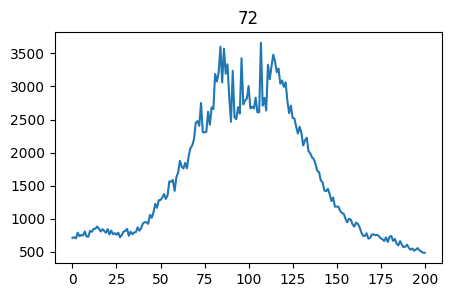

2/2 [==============================] - 0s 3ms/step


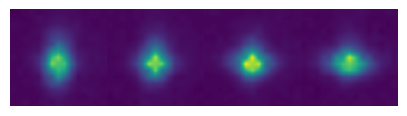

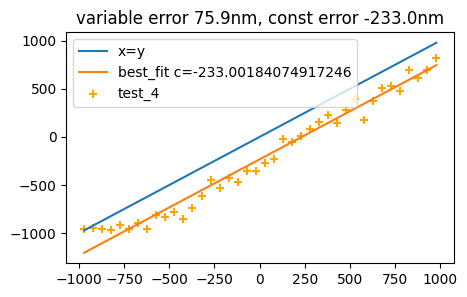

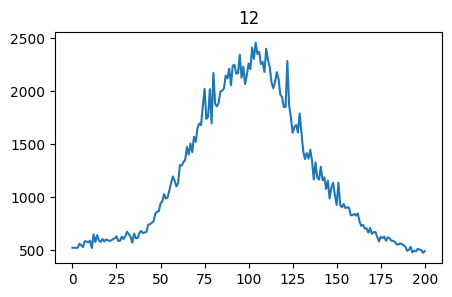

2/2 [==============================] - 0s 4ms/step


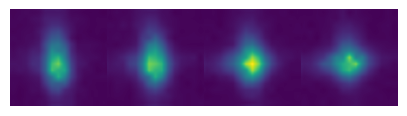

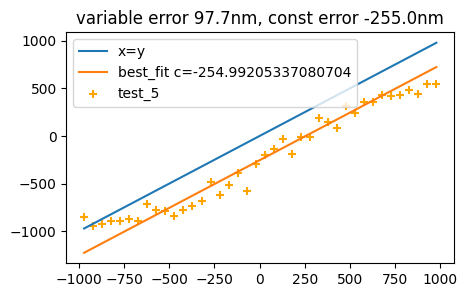

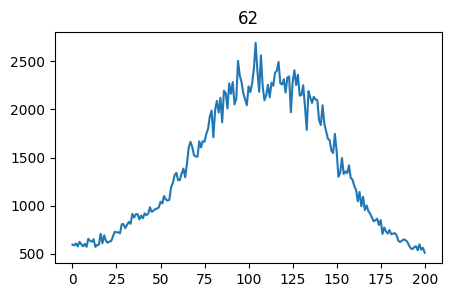

2/2 [==============================] - 0s 4ms/step


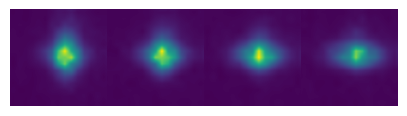

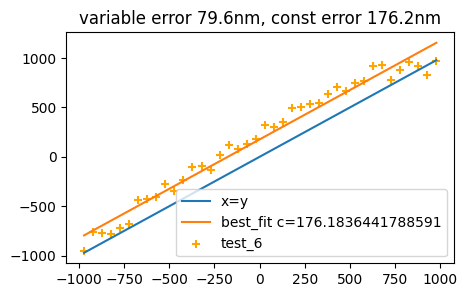

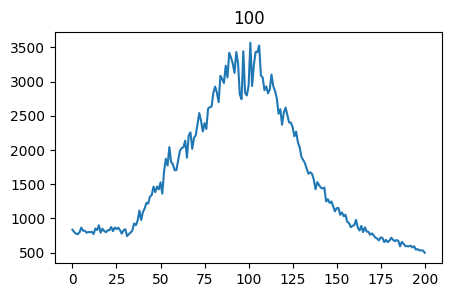

2/2 [==============================] - 0s 4ms/step


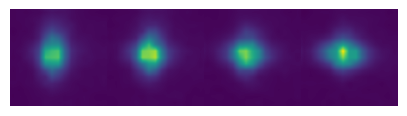

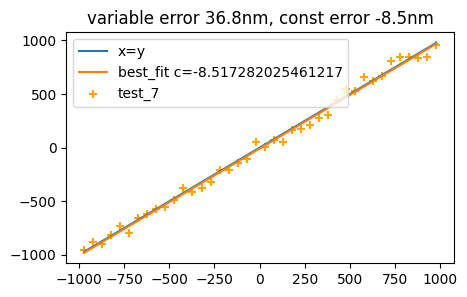

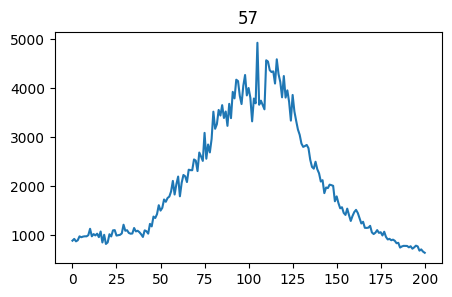

2/2 [==============================] - 0s 4ms/step


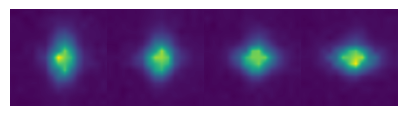

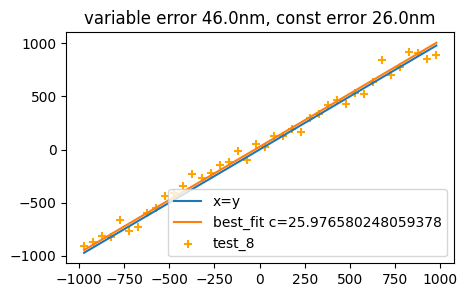

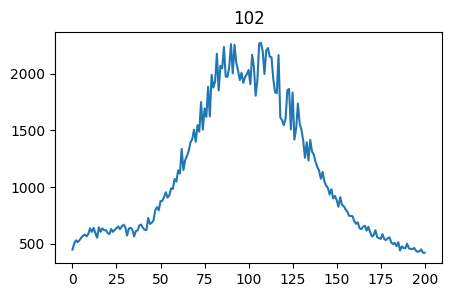

2/2 [==============================] - 0s 4ms/step


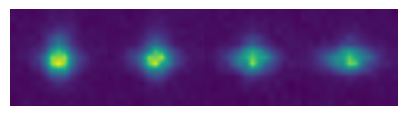

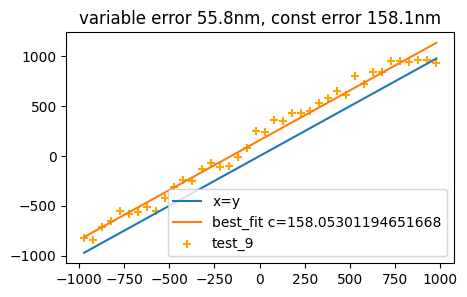

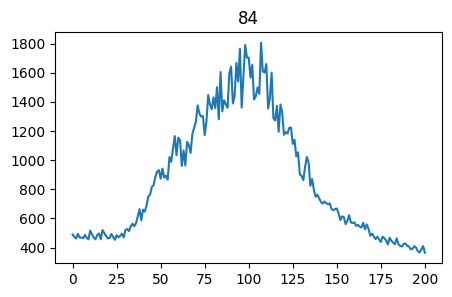

2/2 [==============================] - 0s 4ms/step


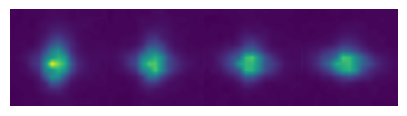

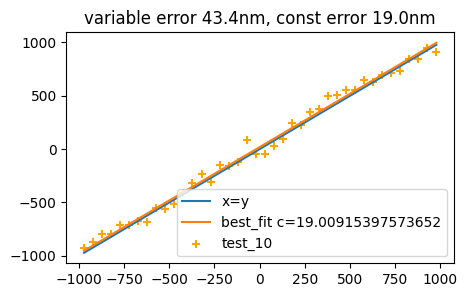

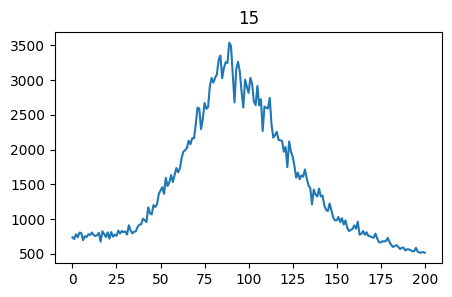

2/2 [==============================] - 0s 3ms/step


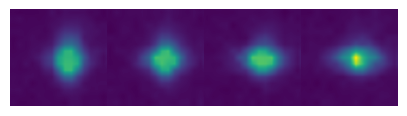

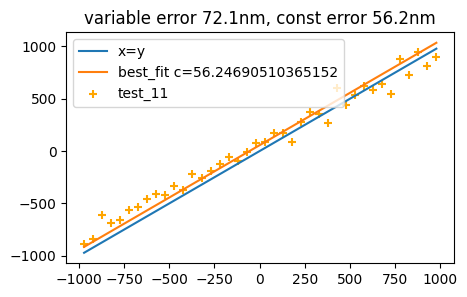

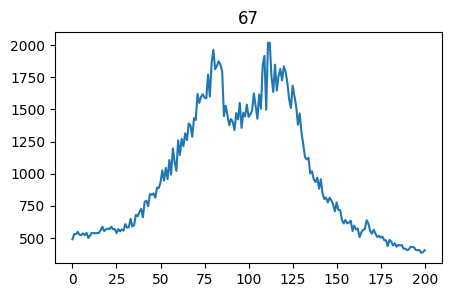

2/2 [==============================] - 0s 3ms/step


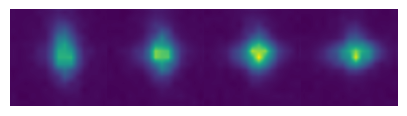

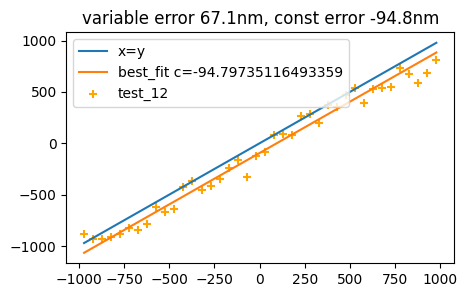

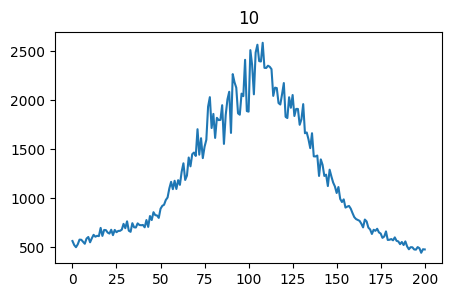

Mean offset 108.461


In [31]:
from sklearn.metrics import mean_absolute_error
import scipy.optimize as opt

plt.rcParams['figure.figsize'] = [5, 3]

def chunk_dataset(train, z):
    splits = [0] + list(np.argwhere(np.diff(z.squeeze()) < 0).flatten()+1) + [inputs[0].shape[0]]
    for i in range(len(splits)-1):
        start = splits[i]
        end = splits[i+1]
        yield (train[0][start:end], train[1][start:end]), z[start:end]

from tqdm import tqdm

from scipy.interpolate import UnivariateSpline
from data.align_psfs import norm_zero_one
UPSCALE_RATIO = 10
def find_peak(psf):
    if psf.ndim == 4:
        psf = psf.mean(axis=-1)
    x = np.arange(psf.shape[0]) * Z_STEP
    inten = norm_zero_one(psf.max(axis=(1,2)))
#   prev 0.8
    cs = UnivariateSpline(x, inten, k=3, s=1.25)

    x_ups = np.linspace(0, psf.shape[0], len(x) * UPSCALE_RATIO) * Z_STEP
    
    peak = x_ups[np.argmax(cs(x_ups))] 
    
#     plt.plot(x-peak, inten, label='raw')
#     plt.plot(x_ups-peak, cs(x_ups), label='fit')
#     plt.legend()
#     plt.show()
    return peak

def bestfit_error(z_true, z_pred):

    def linfit(x, c):
        return x + c

    x = z_true.squeeze()
    y = z_pred.squeeze()
    popt, _ = opt.curve_fit(linfit, x, y, p0=[0])

    x = np.linspace(z_true.min(), z_true.max(), len(y))
    y_fit = linfit(x, popt[0])
    plt.plot(x, x, label=f'x=y')
    plt.plot(x, y_fit, label=f'best_fit c={popt[0]}')

    error = mean_absolute_error(y_fit, y)
    return error, popt[0]


res_offsets = []


for name, dataset in [
#     ('train', (X_train_preproc, y_train)), 
    ('val', (X_val_preproc, y_val)), 
    ('test', (X_test_preproc, y_test))]:
    inputs, z = dataset
    for i, (inp, true_zs) in enumerate(chunk_dataset(*dataset)):
        pred_zs = model.predict(inp)
        show_psf_axial(inp[0].mean(axis=-1))
        find_peak(inp[0])
        
        error, offset = bestfit_error(true_zs, pred_zs)
        res_offsets.append(abs(offset))
#         error = mean_absolute_error(true_zs, pred_zs)
        plt.title(f'variable error {round(error, 1)}nm, const error {round(offset, 1)}nm')
        plt.scatter(true_zs, pred_zs, label=f'{name}_{i}', marker='+', c='orange')
        plt.legend()
        plt.show()
        if name == 'val':
            idx = val_idx
        else:
            idx = test_idx
        psf_idx = idx[i]
        psf = psfs[psf_idx]
        plt.plot(psf.max(axis=(1,2,3)))
        plt.title(str(psf_idx))
        plt.show()

print('Mean offset', round(np.mean(res_offsets), 3))
    


2/2 [==============================] - 0s 3ms/step


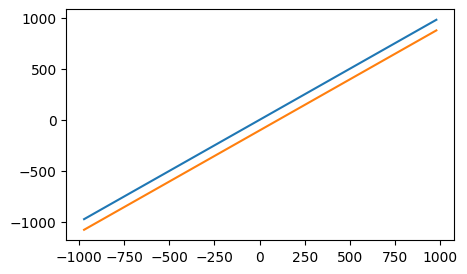

2/2 [==============================] - 0s 3ms/step


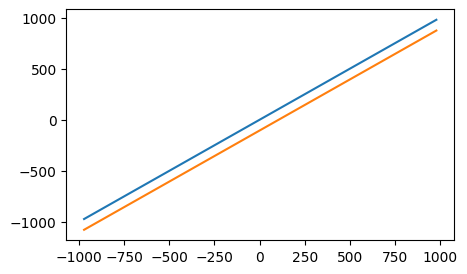

2/2 [==============================] - 0s 3ms/step


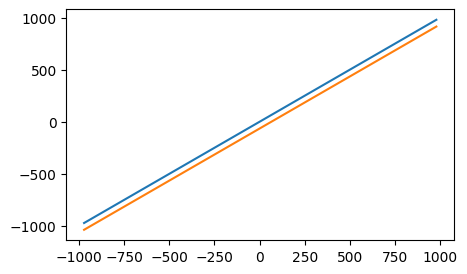

2/2 [==============================] - 0s 3ms/step


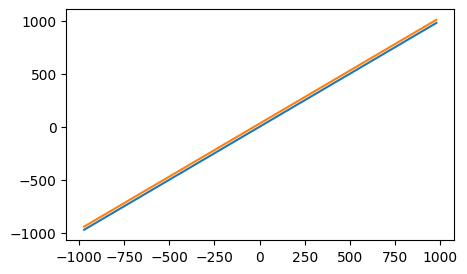

2/2 [==============================] - 0s 3ms/step


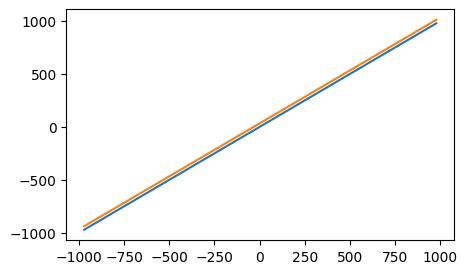

2/2 [==============================] - 0s 3ms/step


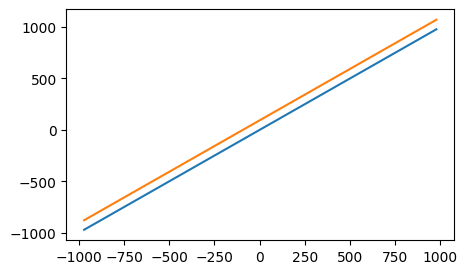

2/2 [==============================] - 0s 3ms/step


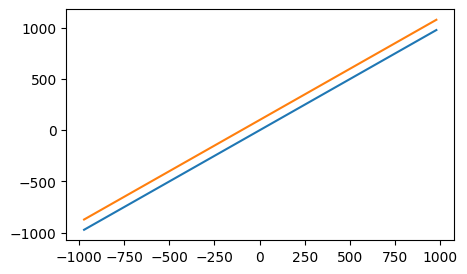

2/2 [==============================] - 0s 3ms/step


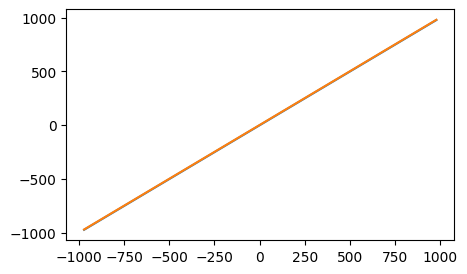

2/2 [==============================] - 0s 3ms/step


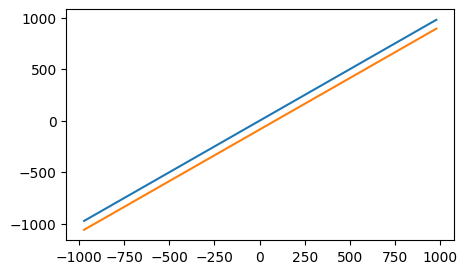

2/2 [==============================] - 0s 3ms/step


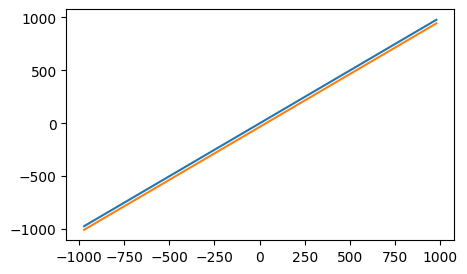

2/2 [==============================] - 0s 3ms/step


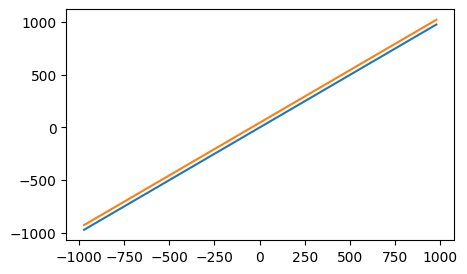

2/2 [==============================] - 0s 3ms/step


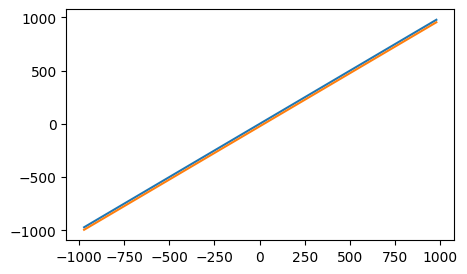

ValueError: x and y must be the same size

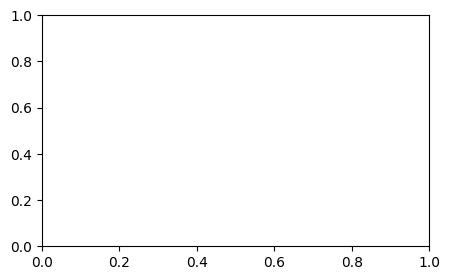

In [32]:
ds = chunk_dataset(X_val_preproc, y_val)
offset_errors = []

for i, (offset, (inp, true_zs)) in enumerate(zip(offsets, ds)):
    pred_zs = model.predict(inp)
    error, offset = bestfit_error(true_zs, pred_zs)    
    plt.show()
    offset_errors.append(offset)
    
offset_errors = np.array(offset_errors)
offset_errors -= offset_errors.min()

plt.scatter(offsets, offset_errors)
plt.plot([0, 1000], [0, 1000], '-')
plt.show()


In [ ]:
# import pandas as pd

# df = pd.read_csv('/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome_locs_40k.csv')

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.scatterplot(data=df, x='x [nm]', y='y [nm]', alpha=0.05)

# xlims = [31000, 33000]
# ylims = [24000, 26000]
# plt.xlim(*xlims)
# plt.ylim(*ylims)
# plt.show()

# pixel_size = 86
# xlim_pixels = [x/pixel_size for x in xlims]
# ylim_pixels= [y/pixel_size for y in ylims]

# print(xlim_pixels)
# print(ylim_pixels)


In [ ]:
import pandas as pd
import h5py
import numpy as np

# MQ_DATA
dirname = '/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/'
locs = 'storm_1_MMStack_Default.ome_locs.hdf5'
spots = 'storm_1_MMStack_Default.ome_spots.hdf5'

# FD-DEEPLOC-data

dirname = '/home/miguel/Projects/uni/data/smlm_3d/fd-deeploc-data/demo2_FD_astig_NPC/'
locs = 'roi_startpos_810_790_split.ome_locs.hdf5'
spots = 'roi_startpos_810_790_split.ome_spots.hdf5'


all_locs = pd.read_hdf(dirname+locs, key='locs')
picked_locs = pd.read_hdf(dirname+locs.replace('_locs', '_locs_picked'), key='locs')

with h5py.File(dirname+spots, 'r') as f:
    spots = np.array(f['spots'])

print(all_locs.shape)
print(picked_locs.shape)
print(spots.shape)


In [ ]:

# Check values in base image vs spots
# from PIL import Image

# d = Image.open('/home/miguel/Projects/uni/data/smlm_3d/20230601_MQ_celltype/nup/fov2/storm_1/storm_1_MMStack_Default.ome.tif')
# print(d.n_frames)
# d.seek(200)
# np.array(d).max()



In [ ]:
# MQ_data_only
if 'demo2_FD_astig_NPC' in dirname:
    xlim = 100, 125
    ylim = 50, 75
    l2 = picked_locs[(xlim[0]<picked_locs['x']) & (xlim[1]>picked_locs['x']) & (ylim[0]<picked_locs['y']) & (ylim[1]>picked_locs['y'])]
    all_locs = all_locs.iloc[l2.index]
    picked_locs = all_locs
    spots = spots[l2.index]


In [ ]:
if all_locs.shape[0] == picked_locs.shape[0]:
    idx = np.arange(all_locs.shape[0])
else:
    all_keys = list(all_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1))
    picked_keys = picked_locs[['bg', 'photons']].astype(str).agg('-'.join, axis=1)
    idx = [all_keys.index(k) for k in picked_keys]

exp_psfs = spots[idx]
print(exp_psfs.shape, picked_locs.shape)
print(exp_psfs.min(), exp_psfs.max())
try:
    print(psfs.min(), psfs.max())
    print(psfs.dtype, exp_psfs.dtype)
except NameError:
    pass

In [ ]:
import matplotlib.pyplot as plt
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs[0:100]))
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3, 3]
sns.scatterplot(data=picked_locs, x='x', y='y', alpha=0.01)
plt.xlim((100, 125))
plt.ylim((50, 75))
plt.show()

In [ ]:
# from jax.numpy.fft import fftn, fftshift, ifftn, ifftshift
# import os

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
# os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.01'

# import jax.numpy as jnp
# import jax
# import numpy as np

# def rms2(ab, pupil):
#     return np.sqrt(np.sum(ab**2) / np.sum(pupil <= 1))


# try:
#     import cupy as cp

#     print('cupy imported')
#     import_cp = True
# except:
#     import_cp = False

# import matplotlib.pyplot as plt


# def rms(pupil):
#     return jnp.sqrt(jnp.mean(jnp.abs(pupil)**2))
          
# def norm_zero_one(psf):
#     return (psf - psf.min()) / (psf.max() - psf.min())


# import poppy 

# KR = None
# THETA = None
# class Simulator:
    
    
# # pixel size (nm) - 115
# # step size (nm) - 20nm
# # magnification - 100x
# # illumination NA
# # NA at sample
# # refractive index at sample - PBS so 1.335
# # illumination wavelength - 635nm
# # detection wavelength - to check


# # #     N = 2048  # points to use in FFT
# #     Nn = 32
# #     pixel_size = 0.115  # camera pixel size
# #     zrange = 1.0  # distance either side of focus to calculate, in microns, could be arbitrary
# #     dz = 0.02  # step size in axial direction of PSF
    
# #     magnification = 100  # objective magnification
# #     ill_NA = 1.4  # numerical aperture at illumination beams
# #     det_NA = 1.1  # numerical aperture at sample
# #     n = 1.335  # refractive index at sample
# #     fwhmz = 3.0  # FWHM of light sheet in z

# #     ill_wavelength = 635  # illumination wavelength in nm
# #     det_wavelength = 635  # detection wavelength in nm

#     def __init__(self, Nn=32, n_coefs=32, pixel_size=0.90, zrange=1.0, dz=0.02, magnification=100, ill_NA=1.4, det_NA=1.1, n=1.335, ill_wavelength=635, det_wavelength=635):
#         self.Nn = Nn # lateral size of output PSF
#         self.pixel_size = pixel_size
#         self.zrange = zrange
#         self.dz = dz # step size in axial direction of PSF
#         self.magnification = magnification
#         self.ill_NA = ill_NA # numerical aperture at illumination beams
#         self.ill_wavelength = ill_wavelength # illumination wavelength in nm
#         self.det_NA = det_NA # numerical aperture at sample
#         self.det_wavelength = det_wavelength # detection wavelength in nm
        
#         self.n = n # refractive index at sample
# #         self.fwhmz = fwhmz
        
        
# #         np.random.seed(RANDOM_SEED)
#         # self.seed(1234)  # set random number generator seed
#         self.ill_wavelength = self.ill_wavelength * 1e-3
#         self.det_wavelength = self.det_wavelength * 1e-3
# #         self.sigmaz = self.fwhmz / 2.355
#         self.dx = self.pixel_size / self.magnification  # Sampling in lateral plane at the sample in um
#         self.dxn = self.det_wavelength / (4 * self.det_NA)  # 2 * Nyquist frequency in x and y.
# #         self.Nn = int(np.ceil(self.N * self.dx / self.dxn / 2) * 2)  # Number of points at Nyquist sampling, even number
        
#         self.N = self.Nn * (self.det_wavelength / (4 * self.det_NA)) / (self.pixel_size / self.magnification)

#         self.dxn = self.N * self.dx / self.Nn  # correct spacing
#         self.res = self.det_wavelength / (2 * self.det_NA)
#         oversampling = self.res / self.dxn  # factor by which pupil plane oversamples the coherent psf data
#         self.dk = oversampling / (self.Nn / 2)  # Pupil plane sampling
#         self.k0 = 2 * jnp.pi * self.n / self.det_wavelength
#         self.kx, self.ky = jnp.meshgrid(jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn),
#                                        jnp.linspace(-self.dk * self.Nn / 2, self.dk * self.Nn / 2 - self.dk, self.Nn))
#         self.kr = jnp.sqrt(self.kx ** 2 + self.ky ** 2)  # Raw pupil function, pupil defined over circle of radius 1.
        
#         self.krmax = self.det_NA * self.k0 / self.n
#         self.kr2 = self.kx ** 2 + self.ky ** 2
#         self.csum = sum(sum((self.kr < 1)))  # normalise by csum so peak intensity is 1

#         self.alpha = jnp.arcsin(self.det_NA / self.n)
#         # Nyquist sampling in z, reduce by 10 % to account for gaussian light sheet
#         self.dzn = 0.8 * self.det_wavelength / (2 * self.n * (1 - jnp.cos(self.alpha)))
#         self.Nz = int(2 * jnp.ceil(self.zrange / self.dz))
#         self.dz = 2 * self.zrange / self.Nz
#         self.Nzn = int(2 * jnp.ceil(self.zrange / self.dzn))
#         self.dzn = 2 * self.zrange / self.Nzn
#         if self.Nz < self.Nzn:
#             self.Nz = self.Nzn
#             self.dz = self.dzn
#         else:
#             self.Nzn = self.Nz
#             self.dzn = self.dz
            
#         self.n_coefs = n_coefs
#         self.zerns = jnp.zeros((n_coefs, Nn, Nn))

#         theta = jnp.arctan2(self.ky, self.kx)
        
#         masked_pupil = np.array(self.kr)
#         masked_pupil[masked_pupil > 1] = 0
#         masked_pupil = norm_zero_one(masked_pupil)
        
#         KR = np.array(self.kr)
#         THETA = np.array(theta)
# #         plt.imshow(KR)
# #         plt.colorbar()
# #         plt.show()
# #         plt.imshow(THETA)
# #         plt.colorbar()
# #         plt.show()
        
#         for i in range(n_coefs):
#             self.zerns = self.zerns.at[i, :, :].set(poppy.zernike.zernike1(i+1, outside=0.0, rho=masked_pupil, theta=np.array(theta)))
            
#             self.zerns = self.zerns.at[i].set(self.zerns[i] * (self.kr<1).astype(int))
            
# #       Remove defocus
#         self.zerns = self.zerns.at[3].set(0)
# #             print(rms2(self.zerns[i], self.kr))
        
#     def get_scalar_psf(self, offset=0, zern_coefs=None):

# #         extra_aberration = jnp.zeros(self.kr.shape)
# #         aberrations = jnp.array([
# #             jnp.ones(self.kr.shape), # piston
# #             2 * self.kx, # tipx
# #             2 * self.ky, # tilt
# #             jnp.sqrt(3) * ((2 * (self.kr**2)) - 1), # defocus
# #             2 * jnp.sqrt(6) * (self.kx * self.ky), # vertical astigmatism
# #             jnp.sqrt(6) * (self.kx**2 - self.ky ** 2), # oblique astigmatism
# #             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.ky, # horizontal coma
# #             2 * jnp.sqrt(2) * (3 * self.kr**2 - 2) * self.kx, # vertical coma
# #             2 * jnp.sqrt(2) * (3 * self.kr**2 - 4 * self.kr**2) * self.ky, # vertical trefoil 
# #             2 * jnp.sqrt(2) * (4 * self.kx**2 - 3 * self.kr**2) * self.kx, # oblique trefoil 
# #             jnp.sqrt(5) * (6 * self.kr**2 * (self.kr**2 - 1) + 1), # primary spherical
# #             jnp.sqrt(10) * (8 * self.kx**4 - 8 * self.kx**2 * self.ky**2 - (3 * self.kx ** 2)), # vertical secondary astigmatism
# #             jnp.sqrt(10) * (4 * self.kx * self.ky) * (4 * self.kx**2 + 4 * self.ky**2 - 3), # oblique secondary astigmatism
# #             jnp.sqrt(10) * ((self.kx**2 - self.ky**2) * (4*self.kx**2 - 3)) ** 2, # vertical quadrafoil
# #             jnp.sqrt(10) * ((2 * self.kx * self.ky) * (self.kx**2 - self.ky**2)) ** 2 # oblique quadrafoil
# #         ])
    

        
        
# #         for custom, p in zip(aberrations, self.zerns):
# #             import numpy as np
# # #             custom = custom.at[~(self.kr<1)].set(0)
# #             custom = norm_zero_one(custom.copy())
# #             p = norm_zero_one(p.copy())
# #             plt.imshow(np.concatenate((custom, p), axis=1))
# #             plt.show()
# #             print(custom.min(), custom.max())
# #             print(p.min(), p.max())
# #         return
        

    
# #         if zern_coefs is not None:
# #             n_coefs = zern_coefs.shape[0]
# #             aberrations = aberrations[:n_coefs]
# #             cust_extra_aberration = jnp.multiply(aberrations, zern_coefs[:, jnp.newaxis, jnp.newaxis]).sum(axis=0)
# #         else:
# #             cust_extra_aberration = 0

#         if zern_coefs is not None:
#             extra_aberration = jnp.sum(self.zerns * zern_coefs[:, jnp.newaxis, jnp.newaxis], axis=0)
#         else:
#             extra_aberration = 0

#         pupil = self.kr < 1
# #         rms_val = rms2(extra_aberration, pupil)
# #         print(np.median(extra_aberration))
# #         plt.title(f'RMS: {rms_val:.2E} min: {extra_aberration.min():.2E} max: {extra_aberration.max():.2E}')
        
# #         plt.imshow(extra_aberration)
# #         plt.show()
        
        
# #         pupil = pupil *  np.exp(1j* aberrations)
# #         nz = 0
# #         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
# #         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
# #             c = (np.exp(
# #                 1j * (z * self.n * 2 * np.pi / self.det_wavelength *
# #                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
# #             psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
# #             nz = nz + 1
    

# #     With aberrations
# #         nz = 0
# #         psf = self.xp.zeros((self.Nzn, self.Nn, self.Nn))
# #         for z in np.arange(-self.zrange, self.zrange - self.dzn, self.dzn):
# #             c = (np.exp(1j * (extra_aberration + z * self.n * 2 * np.pi / self.det_wavelength *
# #                       np.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)))) * pupil
# #             psf = psf.at[nz, :, :].set(abs(np.fft.fftshift(np.fft.ifft2(c))) ** 2 * np.exp(-z ** 2 / 2 / self.sigmaz ** 2))
# #             nz = nz + 1

#         # Optimised version
#         mult1 = self.n * 2 * jnp.pi / self.det_wavelength * jnp.sqrt(1 - (self.kr * pupil) ** 2 * self.det_NA ** 2 / self.n ** 2)
#         zs = jnp.arange(-self.zrange, self.zrange, self.dzn) + offset
#         cs = jax.lax.map(lambda z: (jnp.exp(1j * (extra_aberration + (z * mult1)))) * pupil, zs)
#         psf = abs(jnp.fft.fftshift(jnp.fft.ifft2(cs, axes=(1,2)), axes=(1,2))) ** 2
#         # Normalised so power in resampled psf(see later on) is unity in focal plane
#         psf = psf * self.Nn ** 2 / jnp.sum(pupil) * self.Nz / self.Nzn

#         return psf


# def mask_psf(img, otf_mask, alpha=0.1, beta=1, plot=False):
    
#     fft = fftshift(fftn(img, axes=(1,2)), axes=(1,2))
    

#     att_mask = (1 - beta * jnp.exp(-simul.kr ** 2 / (2 * alpha ** 2)))

    
#     plt.rcParams["figure.figsize"] = (3, 3)

#     mask = att_mask * (otf_mask).astype(int)
    
#     if plot:
#         show_psf_axial(norm_zero_one(np.real(fft)), 'imag')
#         show_psf_axial(norm_zero_one(np.imag(fft)), 'real')        
#         plt.imshow(mask)
#         plt.show()
        
#     fft = fft.at[:].set(jnp.multiply(fft[:], mask))
    
#     if plot:
#         show_psf_axial(norm_zero_one(np.real(fft)), 'imag_masked')
#         show_psf_axial(norm_zero_one(np.imag(fft)), 'real_masked')
#         plt.imshow(att_mask)
#         plt.colorbar()
#         plt.show()
#         plt.imshow(np.imag(fft[50]))
#         plt.show()
#         show_psf_axial(np.imag(fft), 'Masked FFT')
    
#     img2 = np.abs(ifftn(ifftshift(fft, axes=(1,2)), axes=(1,2)))
    
#     if plot:
#         show_psf_axial(img, 'Original')
#         show_psf_axial(img2, 'Denoised')
        
#     img2[img2<0] = 0
#     return img2

# def snr(img):
#     return img.max() / img.mean()


# import time
# n_coefs = 1

# optical_params = dict(Nn=15, 
#                       pixel_size=0.086, 
#                       zrange=1, 
#                       dz=0.02, 
#                       magnification=111.11,
#                       ill_NA=1.4,
#                       det_NA=1.3,
#                       n=1.335,
#                       ill_wavelength=635,
#                       det_wavelength=635)

# simul = Simulator(n_coefs=n_coefs, **optical_params)

# # denoised = mask_psf(psf1, otf_mask=simul.kr <= 2, alpha=0.3, plot=True)
# # print(snr(psf1))
# # print(snr(denoised))

# exp_psfs = mask_psf(exp_psfs, otf_mask=simul.kr <= 2, alpha=0.3, plot=False)

In [ ]:
import matplotlib.pyplot as plt
from data.visualise import grid_psfs
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(grid_psfs(exp_psfs[0:100]))
plt.show()

In [ ]:
import pickle
import keras

with open('./scalers.p', 'rb') as f:
    preprocessors = pickle.load(f)

model = keras.models.load_model('./latest_model/')

datagen = preprocessors['psfs']
coords_scaler = preprocessors['coords']

In [ ]:
from skimage.transform import resize
from tqdm import tqdm
imshape = (128, 128, 3)
exp_psfs = np.stack([resize(psf, imshape) for psf in tqdm(exp_psfs)])
print(exp_psfs.shape)

In [ ]:
print(exp_psfs.min(), exp_psfs.max())

# print(exp_psfs_preproc.min(), exp_psfs_preproc.max())
# print(X_train_preproc[0].min(), X_train_preproc[0].max())
# print(exp_coords_preproc.min(), exp_coords_preproc.max())
# print(exp_psfs_preproc.shape, exp_coords_preproc.shape)

In [ ]:
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 3]
for x in [1]:
    exp_psfs_preproc = datagen.standardize(exp_psfs * x)
    exp_coords_preproc = coords_scaler.transform(picked_locs[['x', 'y']].to_numpy())
    pred_z = model.predict((exp_psfs_preproc, exp_coords_preproc))
    sns.histplot(pred_z.squeeze())
    plt.show()